# Sync local data


In [1]:
# sync data from google drive (first time takes up to 2 hours ;)
!date
!rclone sync vfa-Measurements:/ ../data/Measurements/

Mon Oct  1 19:18:08 CEST 2018
2018/10/01 19:20:01 NOTICE: byspireMonitoring28_12_1402.csv: Duplicate object found in source - ignoring
2018/10/01 19:20:01 NOTICE: Rack_2_3_05_1559.csv: Duplicate object found in source - ignoring
2018/10/01 19:20:01 NOTICE: Rack_2_4_05_1059.csv: Duplicate object found in source - ignoring
2018/10/01 19:20:01 NOTICE: Rack_3_3_05_1558.csv: Duplicate object found in source - ignoring
2018/10/01 19:20:01 NOTICE: Rack_3_4_05_1057.csv: Duplicate object found in source - ignoring


# Parse the local data

In [2]:
import pandas as pd
import sys
import matplotlib.pyplot as plt

sys.path.append("../shared-libraries/")
pd.set_option('display.max_rows', 10)

In [3]:
files = !ls ../data/Measurements/
se_files = pd.Series(files)
se_files

0                  Rack_0_07_06-2108.csv
1                  Rack_0_07_06-2109.csv
2                  Rack_0_07_09-1431.csv
3                  Rack_0_08_05-1523.csv
4                  Rack_0_08_08-1743.csv
                      ...               
6222    byspireMonitoring_21_03-1124.csv
6223    byspireMonitoring_21_03-1243.csv
6224    byspireMonitoring_21_03-1319.csv
6225    byspireMonitoring_22_03-1129.csv
6226    byspireMonitoring_22_03-1143.csv
Length: 6227, dtype: object

In [4]:
# Check the first few characters for different types of files
se_files.str.slice(0,4).value_counts()

Rack    5676
bysp     551
dtype: int64

In [5]:
from data_io import parse_sensor_filename
se_files.apply(parse_sensor_filename)

0       {'RACK': '0', 'FILENAME': 'Rack_0_07_06-2108.c...
1       {'RACK': '0', 'FILENAME': 'Rack_0_07_06-2109.c...
2       {'RACK': '0', 'FILENAME': 'Rack_0_07_09-1431.c...
3       {'RACK': '0', 'FILENAME': 'Rack_0_08_05-1523.c...
4       {'RACK': '0', 'FILENAME': 'Rack_0_08_08-1743.c...
                              ...                        
6222    {'RACK': None, 'FILENAME': 'byspireMonitoring_...
6223    {'RACK': None, 'FILENAME': 'byspireMonitoring_...
6224    {'RACK': None, 'FILENAME': 'byspireMonitoring_...
6225    {'RACK': None, 'FILENAME': 'byspireMonitoring_...
6226    {'RACK': None, 'FILENAME': 'byspireMonitoring_...
Length: 6227, dtype: object

In [6]:
df_inventory = se_files.apply(parse_sensor_filename).apply(pd.Series)
df_inventory

,FILENAME,FILE_TIMESTAMP,PATTERN_NAME,RACK
0,Rack_0_07_06-2108.csv,2018-06-07 21:08:00,1,0
1,Rack_0_07_06-2109.csv,2018-06-07 21:09:00,1,0
2,Rack_0_07_09-1431.csv,2018-09-07 14:31:00,1,0
3,Rack_0_08_05-1523.csv,2018-05-08 15:23:00,1,0
4,Rack_0_08_08-1743.csv,2018-08-08 17:43:00,1,0
...,...,...,...,...
6222,byspireMonitoring_21_03-1124.csv,2018-03-21 11:24:00,2,None
6223,byspireMonitoring_21_03-1243.csv,2018-03-21 12:43:00,2,None
6224,byspireMonitoring_21_03-1319.csv,2018-03-21 13:19:00,2,None
6225,byspireMonitoring_22_03-1129.csv,2018-03-22 11:29:00,2,None


### Check for missed files

In [7]:
df_inventory['PATTERN_NAME'].value_counts(dropna=False)

1      5675
2       542
3         6
NaN       4
Name: PATTERN_NAME, dtype: int64

In [8]:
df_inventory[df_inventory['PATTERN_NAME'].isnull()]

,FILENAME,FILE_TIMESTAMP,PATTERN_NAME,RACK
16,Rack_1.0_22_03_1259.csv.xlsx,NaT,NaN,NaN
5736,byspireMonitoring16_01_0652.csv.xlsx,NaT,NaN,NaN
5738,byspireMonitoring16_01_0939.csv.xlsx,NaT,NaN,NaN
6203,byspireMonitoring_03_01-1355.xlsx,NaT,NaN,NaN


# Load into a uniform
Grab as much metadata as possible along the way

In [9]:
def fallback_csv_reader(fn):
    """
    A only just working csv loader that handles the formats we've seen so far...
    Tests etc when we want to productionize a fixed schema.
    """
    resp = {'FILENAME': fn, 'DF': None, 'DF_EXCEPTION': None}
    
    # assume there is a header
    try:
        df = pd.read_csv("../data/Measurements/"+fn, parse_dates=['Date'])
        if list(df.columns) == list(default_schema[:len(df.columns)]):
            resp['DF'] = df
            resp['HEADER'] = True
            resp['NCOLS'] = len(df.columns)
            resp['NROWS'] = len(df)
            df['FILENAME'] = fn
            return pd.Series(resp)
    except Exception as e:
        pass

    # assume there isn't a header?
    try:
        ncols = len(pd.read_csv("../data/Measurements/"+fn, nrows=1).columns)
        assert len(ncols) > 3
        df = pd.read_csv("../data/Measurements/"+fn, names=default_schema[:ncols], parse_dates=['Date'])
        resp['DF'] = df
        resp['HEADER'] = False
        resp['NCOLS'] = len(df.columns)
        resp['NROWS'] = len(df)
        df['FILENAME'] = fn
        return pd.Series(resp)
    except Exception as e:
        resp['DF_EXCEPTION'] = str(e)
    
    return pd.Series(resp)

default_schema = ['Date', 'Time', 'Air temp', 'Humidity', 'Water level', 'Water temp',
       'EC', 'pH', 'CO2', 'DO']


In [10]:
df_sensor_csv_reader = df_inventory[df_inventory.PATTERN_NAME.notnull()]\
    .FILENAME.apply(fallback_csv_reader)
df_sensor_csv_reader

,DF,DF_EXCEPTION,FILENAME,HEADER,NCOLS,NROWS
0,Date Time Air temp Humidity W...,None,Rack_0_07_06-2108.csv,True,10.0,52.0
1,Date Time Air temp Humidity W...,None,Rack_0_07_06-2109.csv,True,10.0,51.0
2,Date Time Air temp Humidity W...,None,Rack_0_07_09-1431.csv,True,10.0,29.0
3,Date Time Air temp Humidity W...,None,Rack_0_08_05-1523.csv,True,10.0,37.0
4,Date Time Air temp Humidity Wa...,None,Rack_0_08_08-1743.csv,True,10.0,2.0
...,...,...,...,...,...,...
6222,Date Time Air temp Humidity Wa...,None,byspireMonitoring_21_03-1124.csv,False,9.0,9.0
6223,Date Time Air temp Humidity W...,None,byspireMonitoring_21_03-1243.csv,False,9.0,14.0
6224,Date Time Air temp Humidity W...,None,byspireMonitoring_21_03-1319.csv,False,9.0,41.0
6225,Date Time Air temp Humidity Wa...,None,byspireMonitoring_22_03-1129.csv,False,9.0,2.0


In [11]:
df_sensor_csv_reader.DF_EXCEPTION.unique()

array([None, 'No columns to parse from file'], dtype=object)

In [12]:
df_sensor_data = pd.concat(df_sensor_csv_reader.DF.tolist(), sort=False)
df_sensor_data

,Date,Time,Air temp,Humidity,Water level,Water temp,EC,pH,CO2,DO,FILENAME
0,2018-07-06 00:00:00,21:08:19,28.30,47.70,25.0,24.60,1.80,5.20,670.00,6.8,Rack_0_07_06-2108.csv
1,2018-07-06 00:00:00,21:09:19,28.30,47.80,25.0,24.60,1.80,5.20,570.00,6.2,Rack_0_07_06-2108.csv
2,2018-07-06 00:00:00,21:10:19,28.30,47.80,25.0,24.60,1.80,5.20,568.00,6.3,Rack_0_07_06-2108.csv
3,2018-07-06 00:00:00,21:11:19,28.30,47.70,25.0,24.60,1.80,5.20,519.00,6.9,Rack_0_07_06-2108.csv
4,2018-07-06 00:00:00,21:12:19,28.40,47.50,25.0,24.70,1.80,5.20,473.00,6.2,Rack_0_07_06-2108.csv
...,...,...,...,...,...,...,...,...,...,...,...
4,2018-03-22 00:00:00,11:48:21,26.05,45.76,39.0,23.12,1.79,6.65,3.74,NaN,byspireMonitoring_22_03-1143.csv
5,2018-03-22 00:00:00,11:49:21,26.04,45.90,39.0,23.12,1.79,6.65,3.75,NaN,byspireMonitoring_22_03-1143.csv
6,2018-03-22 00:00:00,11:50:21,26.04,45.94,39.0,23.12,1.71,6.66,3.74,NaN,byspireMonitoring_22_03-1143.csv
7,2018-03-22 00:00:00,11:51:21,26.03,46.01,39.0,23.12,1.75,6.66,3.76,NaN,byspireMonitoring_22_03-1143.csv


# Basic QA of data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1228b2048>,
      dtype=object)

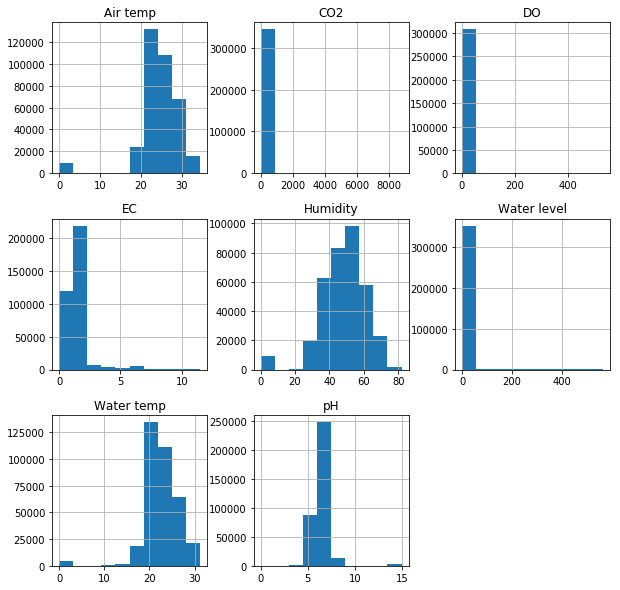

In [13]:
df_sensor_data.hist(figsize=(10,10))

/opt/conda/envs/vfa-01/lib/python3.5/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/envs/vfa-01/lib/python3.5/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


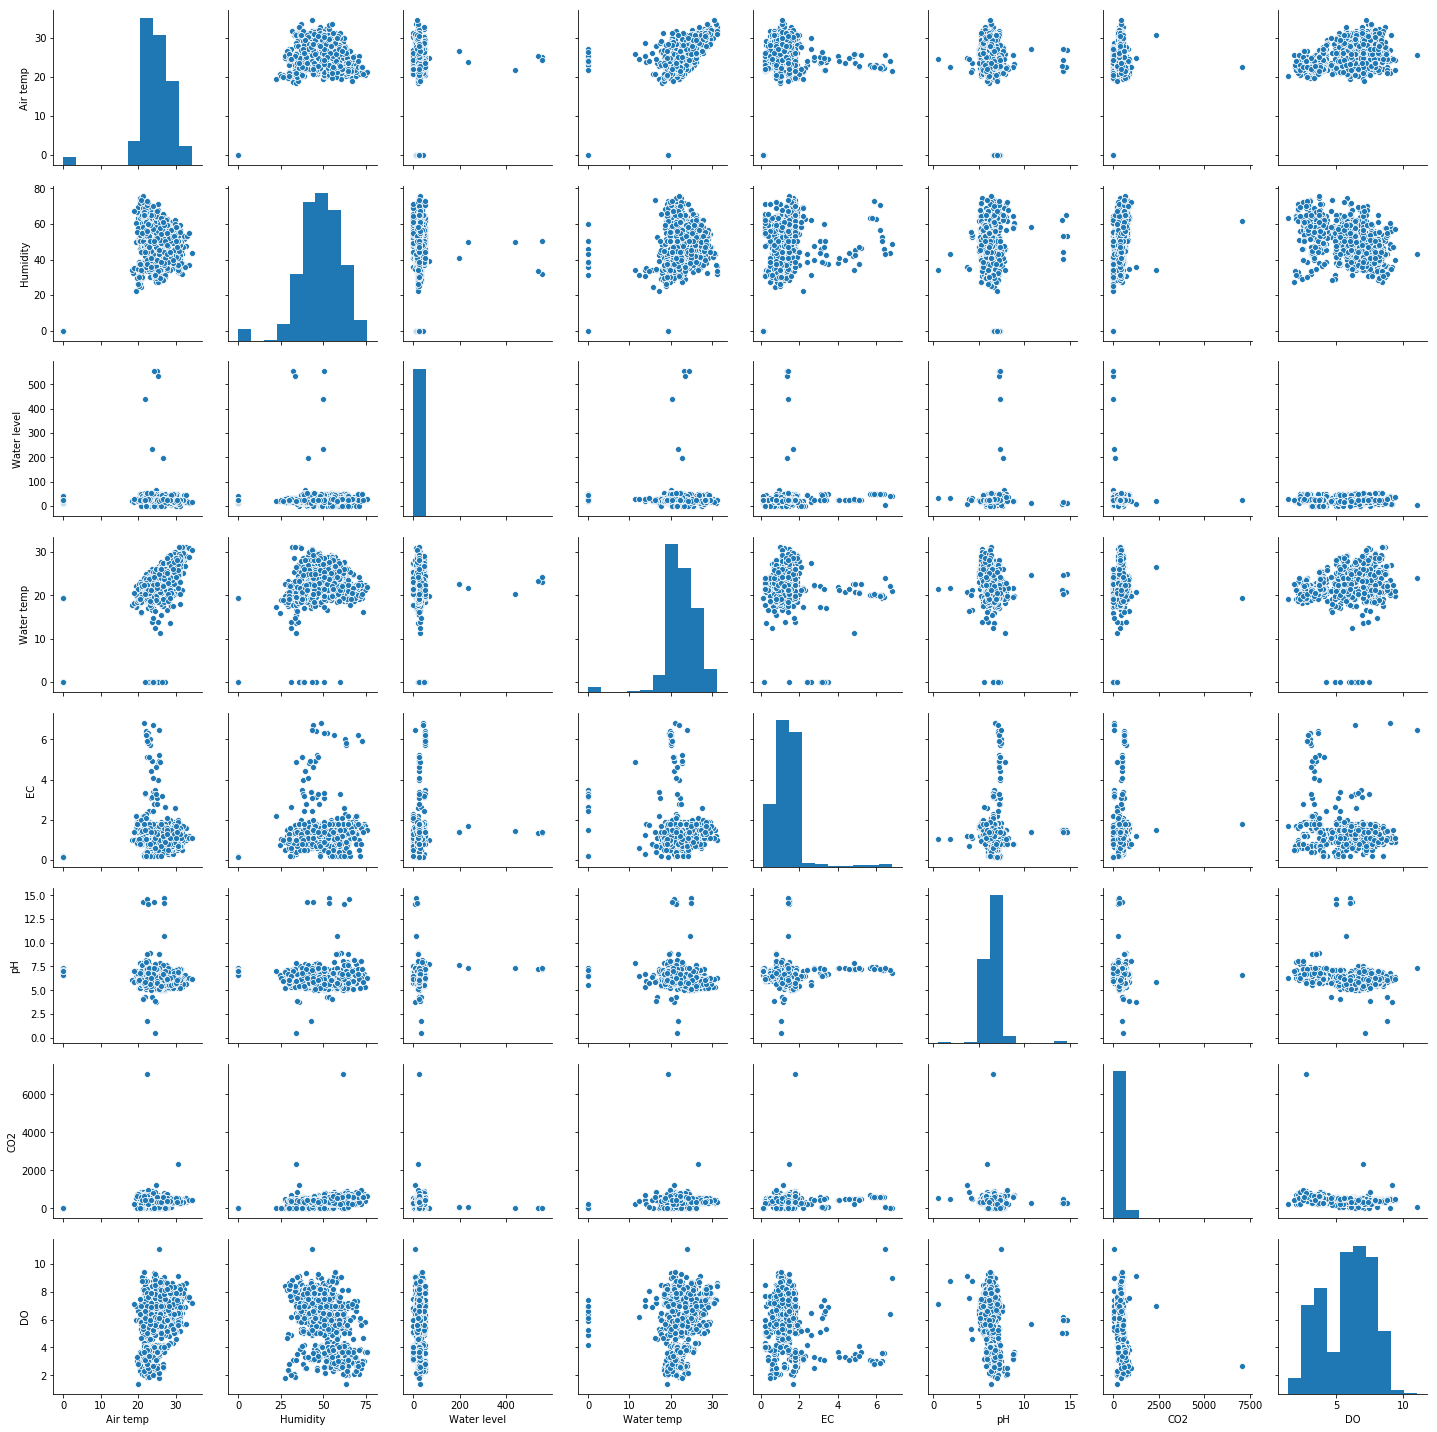

In [14]:
import seaborn as sns
sns.pairplot(df_sensor_data.sample(1000))

# Output dataset

In [15]:
df_sensor_data['DT'] = df_sensor_

,Date,Time,Air temp,Humidity,Water level,Water temp,EC,pH,CO2,DO,FILENAME
0,2018-07-06 00:00:00,21:08:19,28.30,47.70,25.0,24.60,1.80,5.20,670.00,6.8,Rack_0_07_06-2108.csv
1,2018-07-06 00:00:00,21:09:19,28.30,47.80,25.0,24.60,1.80,5.20,570.00,6.2,Rack_0_07_06-2108.csv
2,2018-07-06 00:00:00,21:10:19,28.30,47.80,25.0,24.60,1.80,5.20,568.00,6.3,Rack_0_07_06-2108.csv
3,2018-07-06 00:00:00,21:11:19,28.30,47.70,25.0,24.60,1.80,5.20,519.00,6.9,Rack_0_07_06-2108.csv
4,2018-07-06 00:00:00,21:12:19,28.40,47.50,25.0,24.70,1.80,5.20,473.00,6.2,Rack_0_07_06-2108.csv
...,...,...,...,...,...,...,...,...,...,...,...
4,2018-03-22 00:00:00,11:48:21,26.05,45.76,39.0,23.12,1.79,6.65,3.74,NaN,byspireMonitoring_22_03-1143.csv
5,2018-03-22 00:00:00,11:49:21,26.04,45.90,39.0,23.12,1.79,6.65,3.75,NaN,byspireMonitoring_22_03-1143.csv
6,2018-03-22 00:00:00,11:50:21,26.04,45.94,39.0,23.12,1.71,6.66,3.74,NaN,byspireMonitoring_22_03-1143.csv
7,2018-03-22 00:00:00,11:51:21,26.03,46.01,39.0,23.12,1.75,6.66,3.76,NaN,byspireMonitoring_22_03-1143.csv


In [33]:
!head ../data/Measurements/Rack_3_07_05-1127.csv

DateTimeAir tempHumidityWater levelWater tempECpHCO2DO
07/05/2018,11:27:57,26.8,40.1,20.0,22.2,01.6,06.6,457.0,06.5
07/05/2018,11:28:57,26.8,40.0,19.0,22.2,01.6,06.6,457.0,06.7
07/05/2018,11:29:57,26.8,40.0,21.0,22.2,01.6,06.6,464.0,06.5


In [31]:
df_sensor_data[df_sensor_data.Time.isnull()]

,Date,Time,Air temp,Humidity,Water level,Water temp,EC,pH,CO2,DO,FILENAME
0,DateTimeAir tempHumidityWater levelWater tempE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rack_3_07_05-1127.csv
1,07/05/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rack_3_07_05-1127.csv
2,07/05/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rack_3_07_05-1127.csv
3,07/05/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rack_3_07_05-1127.csv


In [27]:
import time
df_sensor_data['Time'].apply(time.strptime, args=('%H:%M:%S',))

TypeError: strptime() argument 0 must be str, not <class 'float'>